<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Straitforward" data-toc-modified-id="Straitforward-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Straitforward</a></span></li><li><span><a href="#Siamese-classifier" data-toc-modified-id="Siamese-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Siamese classifier</a></span></li></ul></div>

In [1]:
import keras
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

import os
import cv2
import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [ ]:
DATA_FOLDER = "../data/monkey_spicies/"
cats = []
dogs = []

# with open(osp.join(DATA_FOLDER, 'monkey_labels.txt')) as f:
#     for line in f:
#         print line

for fname in os.listdir(DATA_FOLDER):
    print fname
#     if fname.startswith('cat'):
#         cats.append(cv2.resize(cv2.imread(osp.join(DATA_FOLDER, fname)), (224, 224)))
        
#     if fname.startswith('dog'):
#         dogs.append(cv2.resize(cv2.imread(osp.join(DATA_FOLDER, fname)), (224, 224)))

In [5]:
DATA_FOLDER = "../data/monkey_spicies/"
cats = []
dogs = []

for fname in os.listdir(DATA_FOLDER):
    if fname.startswith('cat'):
        cats.append(cv2.resize(cv2.imread(osp.join(DATA_FOLDER, fname)), (224, 224)))
        
    if fname.startswith('dog'):
        dogs.append(cv2.resize(cv2.imread(osp.join(DATA_FOLDER, fname)), (224, 224)))

monkey_labels.txt
training.zip
validation.zip


In [4]:
print len(dogs), len(cats)

12500 12500


In [5]:
cats_train, cats_val, dogs_train, dogs_val = train_test_split(np.asarray(cats), np.asarray(dogs), test_size=0.995)

In [6]:
cats_train.shape

(62, 224, 224, 3)

# Straitforward

In [7]:
cats[0].shape

(224, 224, 3)

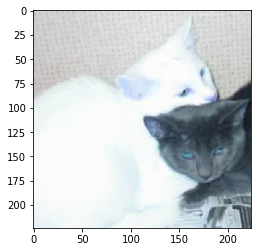

In [8]:
plt.imshow(cats[0])

In [9]:
model = VGG16(include_top=False, weights=None, input_shape=(224, 224, 3))
model.load_weights('../weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
model.trainable = True

In [10]:
predictor = Flatten()(model.output)
predictor = Dense(1024, activation='elu')(predictor)
predictor = Dense(512, activation='elu')(predictor)
predictor = Dense(1, activation='sigmoid')(predictor)

predictor = keras.Model([model.input], [predictor])
predictor.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [11]:
dataset = np.vstack([cats_train, dogs_train])
idxs = np.arange(len(dataset))
labels = np.hstack([np.ones(len(cats_train)), np.zeros(len(dogs_train))])
BATCH_SIZE = 32
NUM_EPOCHS = 100000

predictor.fit(
    dataset[idxs], labels[idxs],
    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
    validation_data=(np.vstack([cats_val, dogs_val]), np.hstack([np.ones(len(cats_val)), np.zeros(len(dogs_val))])))

Train on 124 samples, validate on 24876 samples
Epoch 1/100000
124/124 [==============================] - 75s 607ms/step - loss: 4.5406 - acc: 0.5565 - val_loss: 1.8293 - val_acc: 0.7371
Epoch 2/100000
124/124 [==============================] - 72s 585ms/step - loss: 0.5935 - acc: 0.8952 - val_loss: 0.7122 - val_acc: 0.8561
Epoch 3/100000
124/124 [==============================] - 73s 585ms/step - loss: 0.0894 - acc: 0.9677 - val_loss: 0.5842 - val_acc: 0.8605
Epoch 4/100000
124/124 [==============================] - 72s 583ms/step - loss: 0.0274 - acc: 0.9919 - val_loss: 0.5562 - val_acc: 0.8621
Epoch 5/100000
124/124 [==============================] - 72s 583ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.5442 - val_acc: 0.8667
Epoch 6/100000
124/124 [==============================] - 73s 586ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5431 - val_acc: 0.8677
Epoch 7/100000
124/124 [==============================] - 73s 589ms/step - loss: 9.6528e-04 - acc: 1.0000 - val_loss: 

KeyboardInterrupt: 

# Siamese classifier

In [ ]:
import models.siamese

model = models.siamese.build(
    (256, 256, 3), 1024, 128, 'vgg16'
)

# NOTE: doesn't work with keras
# model.compile(
#     loss=lambda y, x: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=x)),
#     optimizer=keras.optimizers.RMSprop(1e-5),
#     metrics=[]
# )

labels = tf.placeholder(tf.float32, name='labels')

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

global_step = tf.Variable(0, trainable=False)
train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
tf.add_to_collection('train_step', train_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

input_1 = model.input[0]
input_2 = model.input[1]